In [1]:
import requests
import csv
import re
import pandas as pd
import glob
from datetime import datetime
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

Primeiro, iremos fazer a raspagem dos dados dos dois principais portais de notícias do Brasil.
No caso da globo.com, coletamos a editoria (jornalismo, esporte ou entretenimento), o título, o link e a posição que a matéria está na página. Não é possível identificar, pelo número da posição, exatamente onde a matéria está. Para isso, é necessário observar o mapa que (ainda farei) com as posições.

In [2]:
# Função recursiva para coletar editoria de matérias
def pega_editoria(link):
    action = link.attrs.get('data-tracking-action')
    if  not action and link.parent:
        return pega_editoria(link.parent)
    else: return action
    


def coleta_info():
    globo = {}
    num = 0
    
    
    now = datetime.now()
    agora = now.strftime("%d/%m/%Y %H:%M:%S") # colocar a data da raspagem no arquivo
    
    options = Options()
    options.headless = True # isso serve para usar o Selenium sem abrir a janela do navegador
    with webdriver.Chrome(ChromeDriverManager().install(), options=options) as driver:
        driver.get("https://www.globo.com/")
        source = driver.find_element_by_tag_name('html')
        html = source.get_attribute('innerHTML')
        soup = bs(html, 'html.parser')
        for dado in soup.find_all('a', class_="post__link"):
            num += 1
            editoria = pega_editoria(dado)
            titulo = dado.get('title')
            link = dado.get('href')
            globo[f'materia {num}'] = [agora, editoria, titulo, link]
    df = pd.DataFrame({key: pd.Series(value) for key, value in globo.items()}).T
    df.to_csv(f'globo_{now.strftime("%d_%m_%Y_%Hh%Mm")}.csv', encoding='utf-8', index=True)
    
coleta_info()

[WDM] - Current google-chrome version is 96.0.4664
[WDM] - Get LATEST driver version for 96.0.4664


[WDM] - Get LATEST driver version for 96.0.4664
[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/96.0.4664.45/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\victo\.wdm\drivers\chromedriver\win32\96.0.4664.45]


No caso do uol.com, coletamos a class (o que a matéria é), o título, o link e a posição que a matéria está na página. Aqui, no entanto, não conseguimos coletar a editoria. 
Não é possível identificar, pelo número da posição, exatamente onde a matéria está. Para isso, é necessário observar o mapa que (ainda farei) com as posições.

In [3]:
def coleta_uol():
    uol = {}
    num = 0
    
    now = datetime.now()
    agora = now.strftime("%d/%m/%Y %H:%M:%S")
    
    resposta = requests.get("https://www.uol.com.br/")
    html = resposta.text
    soup = bs(html, 'html.parser')
    for texto in soup.find_all('a'):
        next
        if 'class="hyperlink ' in str(texto): # gambiarra
            if 'class="hyperlink showcase' not in str(texto): # gambiarra
                if 'class="hyperlink blackBar' not in str(texto): # gambiarra
                    next
                    num += 1 
                    classe = texto.get('class')[1]
                    link = texto.get('href')
                    tit = texto.text
                    tit = tit.strip()
                    tit = re.sub(r"\n+\s+", ': ', tit)
                    titulo = tit
                    uol[f'materia {num}'] = [agora, classe, titulo, link]
    df = pd.DataFrame({key: pd.Series(value) for key, value in uol.items()}).T
    df.to_csv(f'uol_{now.strftime("%d_%m_%Y_%Hh%Mm")}.csv', encoding='utf-8', index=True)

coleta_uol()

# Agrupar os dados 

Feita a coleta, agora vamos mexer com os dados.
Para isso, vamos criar um código que abre todas as planilhas do mesmo site, usando o glob.

In [147]:
arquivos_globo = []
for arquivo in glob.glob('C:\\Users\\victo\\OneDrive\\Documentos\\analise_jornais\\globo*csv'):
    arquivos_globo.append(arquivo)

tabelas_globo = []
for arquivo in arquivos_globo:
    tabelas_globo.append(pd.read_csv(arquivo, index_col=0))

arq_fim_globo = pd.concat(tabelas_globo).reset_index()
arq_fim_globo = arq_fim_globo.rename(columns={'0': 'data', '1': 'editoria', '2': 'titulo', '3': 'link'})
arq_fim_globo

,index,data,editoria,titulo,link
0,materia 1,18/12/2021 10:21:40,jornalismo,Rosa Weber suspende decreto que esvaziou Conse...,https://g1.globo.com/politica/noticia/2021/12/...
1,materia 2,18/12/2021 10:21:40,esporte,"Resorts, Disney e trap: elenco do Fla mostra a...",https://oglobo.globo.com/esportes/futebol/1022...
2,materia 3,18/12/2021 10:21:40,esporte|bullet,Fla inicia reuniões por técnico com mais um po...,https://ge.globo.com/futebol/times/flamengo/no...
3,materia 4,18/12/2021 10:21:40,esporte,Corinthians vasculha no Brasil e fora por cami...,https://ge.globo.com/futebol/times/corinthians...
4,materia 5,18/12/2021 10:21:40,esporte,Hulk encomenda réplicas de taças pelo Galo no ano,https://ge.globo.com/futebol/times/atletico-mg...
...,...,...,...,...,...
295,materia 96,19/12/2021 11:30:39,jornalismo,Polícia investiga morte de mulher após passar ...,https://g1.globo.com/rj/rio-de-janeiro/noticia...
296,materia 97,19/12/2021 11:30:39,jornalismo,Nova vítima de hidrolipo feita por médico colo...,https://g1.globo.com/rj/rio-de-janeiro/noticia...
297,materia 98,19/12/2021 11:30:39,jornalismo,Rio: Policial Civil que matou universitária po...,https://extra.globo.com/casos-de-policia/polic...
298,materia 99,19/12/2021 11:30:39,jornalismo,Modelo desconvidada de festa de casamento por ...,https://extra.globo.com/noticias/page-not-foun...


In [148]:
arquivos_uol = []
for arquivo in glob.glob('C:\\Users\\victo\\OneDrive\\Documentos\\analise_jornais\\uol*csv'):
    arquivos_uol.append(arquivo)

tabelas_uol = []
for arquivo in arquivos_uol:
    tabelas_uol.append(pd.read_csv(arquivo, index_col=0))

arq_fim_uol = pd.concat(tabelas_uol).reset_index()
arq_fim_uol = arq_fim_uol.rename(columns={'0': 'data', '1': 'classe', '2': 'titulo', '3': 'link'})
arq_fim_uol

,index,data,classe,titulo,link
0,materia 1,18/12/2021 10:21:48,headerDesktop__logo__hyperlink,\n UOL - Seu universo online\n,//www.uol.com.br/
1,materia 2,18/12/2021 10:21:48,headlineMain__link,\n Dados de Bolsonaro e de ministros do...,https://www1.folha.uol.com.br/cotidiano/2021/1...
2,materia 3,18/12/2021 10:21:48,headlineHorizontalLive__link,Pandemia\n Covid: o que é preciso saber...,https://noticias.uol.com.br/ao-vivo/2020/03/18...
3,materia 4,18/12/2021 10:21:48,headlineSub__link,\n Ex-cunhada de Jair Bolsonaro invoca ...,https://noticias.uol.com.br/colunas/juliana-da...
4,materia 5,18/12/2021 10:21:48,relatedList__related,\n Jair Renan não aparece para depor ...,https://www1.folha.uol.com.br/colunas/painel/2...
...,...,...,...,...,...
485,materia 154,19/12/2021 11:29:13,headlineStandard__link,Chuvas no sul da Bahia: estrada vira rio entre...,https://tab.uol.com.br/noticias/redacao/2021/1...
486,materia 155,19/12/2021 11:29:13,headlineStandard__link,Piada com morte de fundador da Mancha causou b...,https://www.uol.com.br/esporte/futebol/ultimas...
487,materia 156,19/12/2021 11:29:13,headlineStandard__link,MP cita colega e ex de Bolsonaro na operação d...,https://noticias.uol.com.br/colunas/juliana-da...
488,materia 157,19/12/2021 11:29:13,headlineStandard__link,Pensadoras negras exaltam relevância de bell h...,https://www.uol.com.br/universa/noticias/redac...


# Agora analisar os dados

In [155]:
arq_fim_globo['titulo'][1]

'Resorts, Disney e trap: elenco do Fla mostra a folga de fim de ano'

In [175]:
#Loading NLTK
import nltk

#String text pega todos os títulos do arquivo
text = ''
for index, row in arq_fim_globo.iterrows():
    text = text + row['titulo'].lower() + ' '

#Sentence Tokenization

#Sentence tokenizer breaks text paragraph into sentences.
from nltk.tokenize import sent_tokenize

tokenized_text=sent_tokenize(text)
tokenized_text

#Word Tokenization

#Word tokenizer breaks text paragraph into words.

from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

from nltk.corpus import stopwords
stop_words=set(stopwords.words("portuguese"))

#adiciona # e @ e pontuação na lista de stopwords
for x in ['seção','@','#',',', '!', ':', '.', 'a', 'diz', 'após', 'veja', 'ser', 'faz']:
  stop_words.add(x)

tokenized_sent = tokenized_word
filtered_sent=[]
for w in tokenized_sent:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_sent)
print("Filterd Sentence:",filtered_sent)


#REmover pontuação
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
filtered_sent = tokenizer.tokenize(' '.join(filtered_sent))
print(filtered_sent)


['rosa', 'weber', 'suspende', 'decreto', 'que', 'esvaziou', 'conselho', 'do', 'meio', 'ambiente', 'resorts', ',', 'disney', 'e', 'trap', ':', 'elenco', 'do', 'fla', 'mostra', 'a', 'folga', 'de', 'fim', 'de', 'ano', 'fla', 'inicia', 'reuniões', 'por', 'técnico', 'com', 'mais', 'um', 'português', 'na', 'lista', 'corinthians', 'vasculha', 'no', 'brasil', 'e', 'fora', 'por', 'camisa', '9', 'hulk', 'encomenda', 'réplicas', 'de', 'taças', 'pelo', 'galo', 'no', 'ano', 'veja', 'os', '2', 'finais', 'da', 'novela', 'giovanna', 'vinga', 'angel', ';', 'veja', 'mais', 'assine', 'globoplay', 'e', 'maratone', 'já', 'vida', 'de', 'tulio', 'fica', 'nas', 'mãos', 'de', 'christian', 'bárbara', 'é', 'cancelada', 'na', 'internet', "'adriana", 'esteves', 'é', 'mãe', 'em', 'todos', 'os', 'sentidos', "'", 'secretário', 'diz', 'que', 'não', 'há', 'surto', 'de', 'gripe', 'e', 'nega', 'campanha', 'extra', 'nova', 'vacina', 'contra', 'gripe', 'deve', 'chegar', 'até', 'março', 'de', '2022', 'ômicron', 'se', 'espal

<FreqDist with 1300 samples and 2337 outcomes>


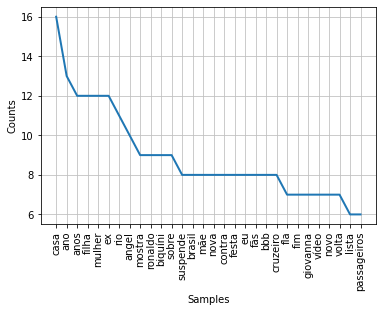

In [176]:
# Frequency Distribution Plot
fdist = FreqDist(filtered_sent)
print(fdist)
fdist.plot(30,cumulative=False)
plt.showb()

In [186]:
# Se quisermos, podemos filtrar por editoria
jornalismo_globo = arq_fim_globo[arq_fim_globo['editoria'].str.contains('jornalismo')]

text = ''
for index, row in jornalismo_globo.iterrows():
    text = text + row['titulo'].lower() + ' '

from nltk.tokenize import sent_tokenize

tokenized_text=sent_tokenize(text)
tokenized_text

from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

from nltk.corpus import stopwords
stop_words=set(stopwords.words("portuguese"))

for x in ['seção','@','#',',', '!', ':', '.', 'a', 'diz', 'após', 'veja', 'ser', 'faz']:
  stop_words.add(x)

tokenized_sent = tokenized_word
filtered_sent=[]
for w in tokenized_sent:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_sent)
print("Filterd Sentence:",filtered_sent)

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
filtered_sent = tokenizer.tokenize(' '.join(filtered_sent))
print(filtered_sent)

['rosa', 'weber', 'suspende', 'decreto', 'que', 'esvaziou', 'conselho', 'do', 'meio', 'ambiente', 'secretário', 'diz', 'que', 'não', 'há', 'surto', 'de', 'gripe', 'e', 'nega', 'campanha', 'extra', 'nova', 'vacina', 'contra', 'gripe', 'deve', 'chegar', 'até', 'março', 'de', '2022', 'ômicron', 'se', 'espalha', "'como", 'um', 'raio', "'", ',', 'diz', 'primeiro-ministro', 'após', 'variante', ',', 'paris', 'cancela', 'festa', 'de', 'réveillon', 'suspensão', 'dos', 'voos', 'da', 'ita', 'pode', 'afetar', '40', 'mil', 'passageiros', 'procon-sp', 'vai', 'notificar', 'a', 'aérea', 'e', 'já', 'fala', 'em', 'multa', 'defesa', 'civil', 'da', 'ba', 'passa', 'a', 'emitir', 'alerta', 'por', 'risco', 'de', 'chuvas', 'sobe', 'a', '14', 'nº', 'de', 'mortos', 'no', 'interior', 'do', 'estado', 'maksoud', 'plaza', 'é', 'lacrado', 'e', 'tem', 'móveis', 'recolhidos', 'empréstimos', 'por', 'casa', 'própria', 'batem', 'r', '$', '150', 'bi', 'petrobras', 'abre', 'o', '1º', 'concurso', 'em', '3', 'anos', ';', 've

<FreqDist with 499 samples and 832 outcomes>


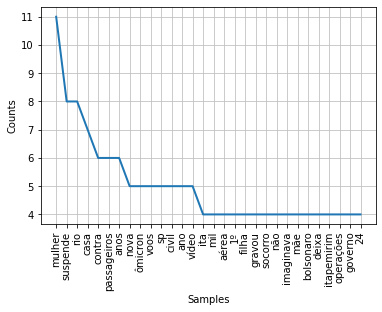

In [188]:
fdist = FreqDist(filtered_sent)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()

In [112]:
# Vamos ver que termos aparecem mais nos título do Uol
arq_fim_uol['titulo']

0                \n      UOL - Seu universo online\n    
1      \n        Dados de Bolsonaro e de ministros do...
2      Pandemia\n        Covid: o que é preciso saber...
3      \n        Ex-cunhada de Jair Bolsonaro invoca ...
4      \n          Jair Renan não aparece para depor ...
                             ...                        
327    Piada com morte de fundador da Mancha causou b...
328    MP cita colega e ex de Bolsonaro na operação d...
329    Drag queen pioneira, Marcia Pantera fala de dr...
330    Pensadoras negras exaltam relevância de bell h...
331                                               ERRATA
Name: titulo, Length: 332, dtype: object

In [181]:
import nltk

text = ''
for index, row in arq_fim_uol.iterrows():
    text = text + row['titulo'].lower()

from nltk.tokenize import sent_tokenize

tokenized_text=sent_tokenize(text)
tokenized_text

from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

from nltk.corpus import stopwords
stop_words=set(stopwords.words("portuguese"))

for x in ['seção','@','#',',', '!', ':', '.', 'a', 'após', 'veja', 'ser', 'faz', 'diz', 'r']:
  stop_words.add(x)

tokenized_sent = tokenized_word
filtered_sent=[]
for w in tokenized_sent:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_sent)
print("Filterd Sentence:",filtered_sent)


from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
filtered_sent = tokenizer.tokenize(' '.join(filtered_sent))
print(filtered_sent)


['uol', '-', 'seu', 'universo', 'online', 'dados', 'de', 'bolsonaro', 'e', 'de', 'ministros', 'do', 'stf', 'são', 'vendidos', 'por', 'criminosos', 'pandemia', 'covid', ':', 'o', 'que', 'é', 'preciso', 'saber', 'sobre', 'a', 'vacinação', 'de', 'crianças', 'ex-cunhada', 'de', 'jair', 'bolsonaro', 'invoca', 'o', 'direito', 'ao', 'silêncio', 'em', 'depoimento', 'ao', 'mp', 'jair', 'renan', 'não', 'aparece', 'para', 'depor', 'na', 'pf', 'em', 'ação', 'sobre', 'sua', 'empresa', 'paulo', 'guedes', 'culpa', 'poderes', 'por', 'lentidão', 'de', 'privatizações', 'e', 'quer', 'vender', 'duas', 'estatais', 'salários', 'atrasados', ',', 'voos', 'cancelados', ',', 'calote', ':', 'veja', 'o', 'que', 'fez', 'itapemirim', 'suspender', 'operações', 'empresa', 'aérea', 'itapemirim', 'suspende', 'temporariamente', 'operações', 'no', 'brasil', 'itapemirim', 'já', 'enfrentava', 'problemas', 'antes', 'de', 'suspender', 'operações', 'aéreas', 'sp', ':', 'passageiros', 'protestam', 'em', 'guarulhos', 'após', 's

<FreqDist with 2019 samples and 3196 outcomes>


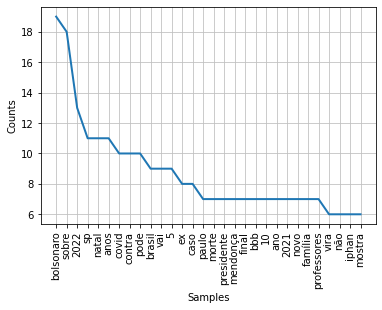

In [182]:
fdist = FreqDist(filtered_sent)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()